# Import Packages

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import datetime
import json 
import h5py as h5
import sys
import matplotlib
from matplotlib import pyplot as plt
from random import shuffle
from sklearn.metrics import precision_recall_curve,average_precision_score,roc_curve,auc,roc_auc_score


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0,5.0)
matplotlib.rcParams.update({'font.size': 12})

# Load Batches of RNN Input Data

In [2]:
def load_next_batch_h5(data_dir,split,num,cap_vals=True):
    '''
    Loads a batch for a .h5 file.  
    Parameters:
        @data_dir: (string) path to .h5 file
        @split: (string) train/dev/test
        @num: (int) batch number
    Returns:
        @x_batch_np: (nd array) x batch data
        @y_batch_np: (nd array) y batch data
    '''
    
    x_batch_h5 = h5.File(data_dir+"%s_x_batch_%d.h5"%(split,num), "r")
    y_batch_h5 = h5.File(data_dir+"%s_y_batch_%d.h5"%(split,num), "r")
    
    x_batch_np = x_batch_h5.get('%s_x_batch_%d' % (split,num)).value
    y_batch_np = y_batch_h5.get('%s_y_batch_%d' % (split,num)).value
    
    
    if cap_vals == True:
        x_batch_np[x_batch_np>100]=100
    
    return x_batch_np,y_batch_np



def load_multiple_batches_h5(data_dir,split,num_batches):
    '''
    Load and concatenates multiple batches.
    Parameters:
        @data_dir: (string) path to .h5 file
        @split: (string) train/dev/test
        @num: (int) batch number
    Returns:
        @x_batch_np: (nd array) x batch data
        @y_batch_np: (nd array) y batch data
    '''
    
    for nb in range(num_batches):
        x_batch_i,y_batch_i = load_next_batch_h5(data_dir,split,nb)
        if nb == 0:
            batch_size = x_batch_i.shape[0]
            Tx = x_batch_i.shape[1]
            n_feats = x_batch_i.shape[2]
            n_y = y_batch_i.shape[2]
            x_batch_np = np.zeros((num_batches * batch_size,Tx,n_feats))
            y_batch_np = np.zeros((num_batches * batch_size,Tx,n_y))

        x_batch_np[(nb*batch_size):((nb+1)*batch_size),:,:] = x_batch_i
        y_batch_np[(nb*batch_size):((nb+1)*batch_size),:,:] = y_batch_i
        
    return x_batch_np,y_batch_np

In [3]:
rnn_train_dir = '/home/ubuntu/cs230/RNN/data/48_hr/train/train_batches_100/'
rnn_dev_dir = '/home/ubuntu/cs230/RNN/data/48_hr/dev/dev_batches_100/'
rnn_test_dir = '/home/ubuntu/cs230/RNN/data/48_hr/test/test_batches_100/'


fns_test = os.listdir(rnn_test_dir)
fns_test_clean = [fn for fn in fns_test if fn[0]=='x']
fns_test_clean.sort()

fns_dev = os.listdir(rnn_dev_dir)
fns_dev_clean = [fn for fn in fns_dev if fn[0]=='x']
fns_dev_clean.sort()
print ("Loading Dev Set...")
x_dev,y_dev = load_multiple_batches_h5(rnn_dev_dir,'dev',23)
print ("Loading Test Set...")
x_test, y_test= load_multiple_batches_h5(rnn_test_dir,'test',23)

Loading Dev Set...
Loading Test Set...


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf
import keras.backend as K
from keras.layers import LSTM,Dense,Activation,Dropout,BatchNormalization,Masking,TimeDistributed
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras import regularizers
import sklearn
from sklearn.metrics import precision_recall_curve,average_precision_score,roc_curve,auc
from sklearn.metrics import precision_recall_fscore_support as pr

Using TensorFlow backend.


# Code for Model Metric Calculation

In [10]:

def weightedLoss(w):
    '''
    Weighted Cross Entropy Loss Function.
    '''
    
    def loss(y_true, y_pred):
    
        y_true_masked = tf.boolean_mask(y_true,tf.not_equal(y_true,-1))
        y_pred_masked = tf.boolean_mask(y_pred,tf.not_equal(y_true,-1))

        cross_entropy = K.binary_crossentropy(y_true_masked, y_pred_masked)
        weight_vector = y_true_masked * w + (1. - y_true_masked) * 1
        weighted_b_ce = weight_vector * cross_entropy
        return tf.reduce_sum(K.mean(weighted_b_ce))
        
    return loss



def binary_accuracy_V3(y_true, y_pred):
    '''
    Calculates the masked mean accuracy rate across all predictions for binary
    classification problems.
    '''
    t0 = tf.equal(y_true, 0)
    t1 = tf.equal(y_true, 1)
    p0 = tf.equal(tf.round(y_pred), 0)
    p1 = tf.equal(tf.round(y_pred), 1)
    everything = tf.reduce_sum(tf.cast(t0, tf.float32)) + tf.reduce_sum(tf.cast(t1, tf.float32))
    positives = tf.reduce_sum(tf.cast(tf.logical_and(t0, p0), tf.float32)) + tf.reduce_sum(tf.cast(tf.logical_and(p1, t1), tf.float32))
    return positives / everything


def f1_V2(y_true,y_pred):
    '''
    Calculates F1 score
    '''
    K.set_epsilon(1e-05)
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(tf.multiply(y_true, tf.cast(tf.not_equal(y_true, -1), tf.float32)) * tf.multiply(y_pred, tf.cast(tf.not_equal(y_true, -1), tf.float32)), 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(tf.multiply(y_pred, tf.cast(tf.not_equal(y_true, -1), tf.float32)), 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(tf.multiply(y_true, tf.cast(tf.not_equal(y_true, -1), tf.float32)) * tf.multiply(y_pred, tf.cast(tf.not_equal(y_true, -1), tf.float32)), 0, 1)))
        possible_positives = K.sum(K.round(K.clip(tf.multiply(y_true, tf.cast(tf.not_equal(y_true, -1), tf.float32)), 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))


def recall_v2(y_true,y_pred):
    '''
    Calculates masked recall
    '''
    K.set_epsilon(1e-05)

    y_true_masked = K.round(tf.boolean_mask(y_true,tf.not_equal(y_true,-1)))
    y_pred_masked = K.round(tf.boolean_mask(y_pred,tf.not_equal(y_true,-1)))
    
    true_positives = K.sum(tf.multiply(y_true_masked,y_pred_masked))
    possible_positives = K.sum(tf.cast(tf.equal(y_true_masked,1),tf.float32))
    
    recall = true_positives / (possible_positives + K.epsilon())
    return recall



def precision_v2(y_true,y_pred):
    '''
    Calculates masked precision.
    '''
    y_true_masked = K.round(tf.boolean_mask(y_true,tf.not_equal(y_true,-1)))
    y_pred_masked = K.round(tf.boolean_mask(y_pred,tf.not_equal(y_true,-1)))

    true_positives = K.sum(tf.multiply(y_true_masked,y_pred_masked))
    predicted_positives = K.sum(tf.cast(tf.equal(y_pred_masked,1),tf.float32))

    precision = true_positives / (predicted_positives + K.epsilon())

    return precision
 


def init_model_tracking():
    '''
    Tracks model performance during training.
    '''
    d = {}
    keys = ['train_loss','train_acc','train_f1', 'train_precision','train_recall']
    for k in keys:
        d[k] = []
    
    return d

def update_tracking(d,metrics):
    '''
    Updates model tracking during training.
    '''
    zipped = dict(zip(['train_loss','train_acc','train_f1','train_precision','train_recall'],metrics))
    for key,val in zipped.items():
        d[key].append(val)
    return d


In [11]:

def LSTM_model(parameters,batch_size):
    '''
    Defines the LSTM model in Keras.
    Parameters:
        @parameters: (python dict) parameter values
            @Tx: (int) number of input timesteps (maximum)
            @n_a: (list of ints) number of hidden units for each LSTM layer
            @n_feats: (int) number of features per timestep
            @n_layers: (int) number of LSTM layers 
            @n_y: (int) number of items to be predicted
            @dropout: (list of floats) dropout rate for each layer
            @lr: (float) learning rate
            @pw: (int) positive weight
    Returns:
        @model: (Keras Model) LSTM model
    '''
    
    model = Sequential()
    model.add(Masking(mask_value=-1., input_shape=(parameters['Tx'], parameters['n_feats'])))
    for l in range(parameters['num_layers']-1):
        model.add(LSTM(units=parameters['num_neurons'][0],return_sequences=True,kernel_regularizer=regularizers.l1(parameters['lambda']),dropout=parameters['dropout_rate'][l]))
    model.add(LSTM(units=parameters['num_neurons'][0],return_sequences=True,kernel_regularizer=regularizers.l1(parameters['lambda']),dropout=parameters['dropout_rate'][-1]))
    
    model.add(TimeDistributed(Dense(parameters['n_y'],activation='sigmoid',kernel_regularizer=regularizers.l1(parameters['lambda']))))
    
    opt = Adam(lr=parameters['learning_rate'])
    model.compile(loss=weightedLoss(parameters['pw']),optimizer=opt)
    
    return model




In [12]:

def calculate_all_metrics(y_true,y_pred):
    '''
    Wrapper for calculating model metrics.
    '''
    y_pred = tf.convert_to_tensor(y_pred,tf.float32)
    y_true = tf.convert_to_tensor(y_true,tf.float32)
    acc = K.eval(binary_accuracy_V3(y_true,y_pred))
    precision = K.eval(precision_v2(y_true,y_pred))
    recall = K.eval(recall_v2(y_true,y_pred))
    f1 = 2./((1./recall)+(1./precision))
    try:
        auroc = roc_auc_score(y_true,y_pred)
    except:
        auroc = None
    
    return acc,f1,precision,recall,auroc


def run_lstm_model(parameters,data_dir,batch_size,total_samples):
    '''
    Wrapper for running and testing the LSTM model with set of parameters
    '''
    
    model = LSTM_model(parameters,batch_size)
    print (model.summary())
    n_batches = int(total_samples/batch_size)
    
    model_tracking = init_model_tracking()
    
    for e in range(parameters['epochs']):
        start_index = 0
        random_batches = np.arange(0,n_batches)
        shuffle(random_batches)
        for b,rb in enumerate(random_batches):
            if b % 5 == 0: print ("Batch %d"%b)
            x_batch,y_batch = load_next_batch_h5(data_dir,'train',rb)
            loss_b = model.train_on_batch(x_batch,y_batch)
            if b  % 20 == 0: 
                
                batch_metrics = [loss_b]
                y_pred = model.predict(x_batch)
                acc,f1,precision,recall = calculate_all_metrics(y_batch,y_pred)
                
                batch_metrics.extend([acc,f1,precision,recall])
                model_tracking = update_tracking(model_tracking,batch_metrics)
                print ("\r(Epoch: % d, Batch %d):" % (e,b))
                print ("\r\t train_loss: %.3f \n\t train_acc: %.3f \n\t train_f1: %.3f \n\t train_precision: %.3f \n\t train_recall: %.3f" % (tuple(batch_metrics)))
                
                
    train_dict = dict(zip(['train_loss','train_acc','train_f1','train_precision','train_recall'],batch_metrics))
    return model,train_dict,loss_b,model_tracking


# Hyperparamter Search

In [13]:


import math
# if scale == None: generates uniform random value between start/end
# if scale == 'log': generate random variable r in [log(start),log(end)], then return 10^r
#     ex. if you input start:0.0001, end:1 it will return 10^r, where r in [-4,0]
def random_search(start, end, scale='uniform'):
    if scale == 'uniform':
        return np.random.uniform(start, end)
    elif scale == 'int':
        return np.random.randint(start,end)
    elif scale == 'log':
        a = math.log(start, 10)
        b = math.log(end, 10)
        r = np.random.uniform(a, b)
        return 10**r
    else:
        return 'ERROR'

# get random value from list
def random_grid_search(vals):
    length = len(vals)
    return vals[np.random.randint(0,length)]

def decrement_num_neurons(first, min_val, num_layers):
    layers = [first]
    random = np.random.rand()
    if random > 0.5:
        random = 50
    else:
        random = 0
    prev = first
    for j in range(num_layers-1):
        prev = max(prev-50, min_val) 
        layers.append(prev)
    return layers

def dropout_search(num_layers):
    possible_vals = [0.4,0.35,0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0]
    d = []
    prev = None
    for l in range(num_layers-1):
        if l == 0:
            dl = possible_vals[np.random.randint(0,len(possible_vals))]
            d.append(dl)
            prev = dl
        else:
            dl = possible_vals[np.random.randint(0,len(possible_vals))]
            while dl > prev:
                dl = possible_vals[np.random.randint(0,len(possible_vals))]
            d.append(dl)
            prev = dl
    d.append(0)
    return d


def initialize_keys(d,now):
    keys = ['parameters','train_loss','train_f1','val_f1', 'train_acc', 'val_acc', 'val_f1']
    new_entry = {}
    for k in keys:
        new_entry[k] = []
        
    d[now] = new_entry
    
    return d



def update_dicts(d, train_d,val_d, now, params):
    
    d[now]['parameters'] = params
    d[now]['train_loss'] = str(train_d['train_loss'])
    #d[now]['val_loss'] = str(val_d['val_loss'])
    d[now]['train_f1'] = str(train_d['train_f1'])
    d[now]['train_acc'] = str(train_d['train_acc'])
    d[now]['val_acc'] = str(val_d['val_acc'])
    d[now]['val_f1'] = str(val_d['val_f1'])
    
    return d




# Plotting Functions

In [68]:

def plot_track(vals,name,title,ylab,label,n_batches,num_epochs,xlab='epochs',step=20,color='r'):
    '''
    Plots graphs
    '''
    batch_fraction = 1./n_batches
    y = vals

    x = np.linspace(0,num_epochs,num=len(y))
    epoch_idx = np.arange(0,len(vals),int(int(n_batches/step)))

    plt.plot(x,y,color=color,label=label)
    plt.title(title)

    plt.xticks(np.asarray(x)[epoch_idx],np.arange(0,num_epochs+0.01))
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.legend(loc='lower right')
    plt.show()
    
    return


def graph_tracking(model_tracking,n_batches,num_epochs):
    '''
    Plots all data for training.
    '''
    for key,val in model_tracking.items():
        if key == 'train_loss':
            name = 'Training Loss'
            title = 'Training Loss'
            ylab = 'Loss'
        elif key == 'train_acc':
            name = 'Training Accuracy'
            title = 'Training Accuracy'
            ylab = 'Accuracy'
        elif key == 'train_recall':
            name = 'Training Recall'
            title = 'Training Recall'
            ylab = 'Recall'
        elif key == 'train_precision':
            name = 'Training Precision'
            title = 'Training Precision'
            ylab = 'Precision'
        elif key == 'train_f1':
            name = 'Training F1 Score'
            title = 'Training F1 Score'
            ylab = 'F1 Score'
        
        plot_track(val,key,name,title,ylab,n_batches,num_epochs)
    
    
    return


def plot_roc_curve(y_true, y_pred,title,text,show=True,color='r'):
    '''
    Plots a ROC curve for given set of predictions
    
    parameters:
        @y_true: truth values
        @y_pred: prediction values
        @title: graph title
        @text: legend text
        @show: whether to plot labels 
        @color: color of line
    return:
        None
    '''
    
    
    fpr, tpr, _ = roc_curve(y_true,y_pred,pos_label=1)

    AUROC = auc(fpr,tpr)
    plt.plot(fpr,tpr,label=text + ' (AUC = %.3f)' % AUROC,color=color)
    
    plt.legend(loc='lower right')
    if show == True:
        
        plt.title(title)
        plt.xlabel('1 - Specificity')
        plt.ylabel('Sensitivity')
    
    return


def plot_pr_curve(y_true,y_pred,title,text,show=True,color='r'):
    '''
    Plots a PR Curve for a given set of predictions
    
    parameters:
        @y_true: truth values
        @y_pred: prediction values
        @title: graph title
        @text: legend text
        @show: whether to plot labels 
        @color: color of line
    return:
        None
    '''    

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred,pos_label=1)
    auc_pr = auc(recall,precision)
    
    plt.plot(recall,precision,label=text + ' (AUC = %.3f)' % auc_pr,color=color)
    plt.legend(loc='upper right')
    if show == True:
    
        
        plt.title(title)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        
    return

# Search for Hyperparameters and Run Model

In [ ]:

pw_low = 2
pw_high = 15
learning_rate_low = 0.00001
learning_rate_high = 0.01
num_layers_low = 1
num_layers_high = 3
num_neurons_1 = list(np.arange(600,2000,50))
dropout_low = 0
dropout_high = 0.4
num_epochs = 2
batch_size = 64
total_samples = batch_size * 405
n_feats = 9290
Tx = 100
n_y = 2994

model_dicts = {}

f_score_max = -1

model_time_start = str(datetime.datetime.now())
for i in range(1):
    K.clear_session()

    now = str(datetime.datetime.now())
    model_dicts = initialize_keys(model_dicts,now)

    iteration_param_dict = {}
    pw = random_search(pw_low,pw_high, scale='int') # positive weight 
    learning_rate = random_search(learning_rate_low,learning_rate_high,scale='log')
    num_layers = random_search(num_layers_low,num_layers_high, scale='int')
    num_layers = 1
    num_neurons = decrement_num_neurons(random_grid_search(num_neurons_1), 50, num_layers)
    dropout = [random_search(dropout_low, dropout_high, 'uniform') for i in range(len(num_neurons))]
    dropout = dropout_search(num_layers)
    lam = float(np.random.randint(1,5))/1000

    iteration_param_dict['n_feats'] = n_feats
    iteration_param_dict['Tx'] = Tx
    iteration_param_dict['n_y'] = n_y
    iteration_param_dict['pw'] = pw
    iteration_param_dict['learning_rate'] = learning_rate
    iteration_param_dict['num_layers'] = num_layers
    iteration_param_dict['num_neurons'] = num_neurons
    iteration_param_dict['activation'] = 'relu'
    iteration_param_dict['dropout_rate'] = dropout
    iteration_param_dict['epochs'] = num_epochs
    iteration_param_dict['lambda'] = lam
    print('########')
    print(iteration_param_dict)

    model_i,train_dict_i,loss_i,model_tracking = run_lstm_model(iteration_param_dict,rnn_train_dir,batch_size,total_samples)
    y_preds_dev = model_i.predict(x_dev)
    dev_metrics = calculate_all_metrics(y_dev,y_preds_dev)

    dev_dict_i = dict(zip(['val_acc','val_f1','val_precision','val_recall'],dev_metrics))

    model_dicts = update_dicts(model_dicts, train_dict_i, dev_dict_i, now, iteration_param_dict)
    print (model_dicts)
    with open('model_dictionaries_rnn/rnn_model_dictionary_{}.json'.format(model_time_start), 'w') as mdj:
        json.dump(model_dicts, mdj,default=str)

    if dev_dict_i['val_f1'] > f_score_max:
        f_score_max = dev_dict_i['val_f1']
        model_i.save('best_models_rnn/RNN_Best_Model_{}.h5'.format(model_time_start))
        best_model = model_i
        best_weight = iteration_param_dict['pw']
                
        

In [ ]:
graph_tracking(model_tracking,int(total_samples/batch_size),num_epochs)

In [84]:
y_test_bools = y_test!=-1
y_test_masked = y_test[y_test!=-1]


In [85]:
best_preds_masked = best_preds[y_test_bools]

In [ ]:
import keras
from keras.utils import CustomObjectScope

best_weight = 5

with CustomObjectScope({'loss':weightedLoss(best_weight)}):
    model_load = keras.models.load_model('best_models_rnn/RNN_Best_Model_2018-03-20 01:58:16.765533.h5')

In [ ]:
model_load.evaluate(x_test,y_test)

# Compare to Baseline

In [87]:
x_train,y_train = load_multiple_batches_h5(rnn_train_dir,'train',405)

total_predictions = np.sum(y_train[y_train==1])
num_timelines = y_train.shape[0]
num_timesteps = y_train.shape[1]

y_train_mask = np.copy(y_train)

item_orders = np.sum(np.sum(y_train_mask,axis=0),axis=0)
top25_idx = item_orders.argsort()[-25:][::-1]


In [88]:
baseline_response_mat = np.zeros(y_test.shape)

baseline_response_mat[:,:,top25_idx] = 1
y_test_bools = y_test!=-1
y_test_masked = y_test[y_test!=-1]

baseline_response_mat = baseline_response_mat[y_test_bools]
baseline_flat_masked = baseline_response_mat.flatten()

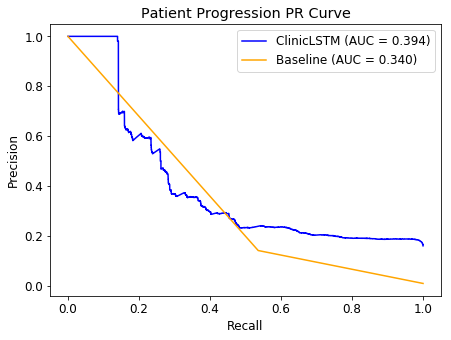

In [93]:
plot_pr_curve(y_test_masked, best_preds_masked,'Patient Progression PR Curve','ClinicLSTM',show=True,color='b')
plot_pr_curve(y_test_masked,baseline_flat_masked,'Majority Precision-Recall Curve','Baseline',show=False,color='orange')


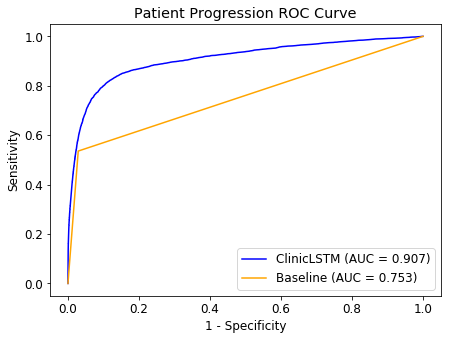

In [91]:
plot_roc_curve(y_test_masked, best_preds_masked,'Patient Progression ROC Curve','ClinicLSTM',show=True,color='b')
plot_roc_curve(y_test_masked,baseline_flat_masked,'Majority Precision-Recall Curve','Baseline',show=False,color='orange')
